In [42]:
import argparse
import os
import matplotlib.pyplot as plt
import numpy as np
import torch
import json
import time
import torch.nn.functional as F
import sys
import cnn_drone_net_utils
import torchvision
import torchvision.transforms as transforms
from torch.utils.tensorboard import SummaryWriter
from torchvision import datasets, transforms, models
from sklearn.model_selection import train_test_split
from torch import nn, optim
from torch.utils.data import Dataset, DataLoader
from pathlib import Path
from PIL import Image
from matplotlib.pyplot import figure

In [43]:
# To start tensorboard in CMD run: 'tensorboard --logdir=runs'

In [44]:
TENSORBOARD_PATH = "runs"
DATA_PATH = "./data"
OUT_PATH = "./output"
DATA_UAV = "UAV_Dataset"
DATA_UAV_COMPRESSED_FILENAME = f"{DATA_UAV}.zip"
DATA_BLOB_UAV_COMPRESSED = "https://nlpdatastorage.blob.core.windows.net/cnndata/UAV_Dataset.zip"

In [45]:
os.makedirs(OUT_PATH, exist_ok=True)
os.makedirs(DATA_PATH, exist_ok=True)

In [50]:
# Remove old tensorboard runs
# import os, shutil
# folder = f"./{TENSORBOARD_PATH}"
# for filename in os.listdir(folder):
#     file_path = os.path.join(folder, filename)
#     try:
#         if os.path.isfile(file_path) or os.path.islink(file_path):
#             os.unlink(file_path)
#         elif os.path.isdir(file_path):
#             shutil.rmtree(file_path)
#     except Exception as e:
#         print('Failed to delete %s. Reason: %s' % (file_path, e))

In [29]:
############## TENSORBOARD ########################
writer = SummaryWriter(TENSORBOARD_PATH)
###################################################

In [30]:
download_data =  DATA_UAV_COMPRESSED_FILENAME not in os.listdir(DATA_PATH) 
zipped = f'{DATA_PATH}/{DATA_UAV_COMPRESSED_FILENAME}'
if(download_data):
    print(f"Download data from {DATA_BLOB_UAV_COMPRESSED} and saving in {zipped}")
    cnn_drone_net_utils.download_data(DATA_BLOB_UAV_COMPRESSED, out_path=zipped)

print(f"Unzipping {zipped} to directory {DATA_PATH} and created folders: {', '.join(os.listdir(f'{DATA_PATH}/{DATA_UAV}'))}")
cnn_drone_net_utils.unzip_file(zipped, DATA_PATH)

Unzipping ./data/UAV_Dataset.zip to directory ./data and created folders: FlightZone, NonFlightZone


In [31]:
##### Hyper Parameters #####

lr = 0.003
batch_size = 8
dropout = 0.2

In [32]:
data_dir = f'{DATA_PATH}/{DATA_UAV}'
train_loader, test_loader = cnn_drone_net_utils.load_split_train_test(data_dir, .2, batch_size = batch_size)
print(f'Initialized data loaders, classes: {train_loader.dataset.classes}')

Initialized data loaders, classes: ['FlightZone', 'NonFlightZone']


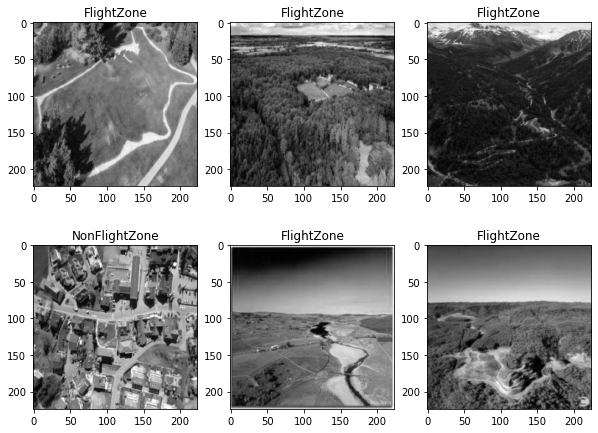

In [33]:
# Sampling data set
examples = iter(test_loader)
example_data, example_targets = examples.next()

figure(num=None, figsize=(10, 7.5))

for i in range(6):
    plt.subplot(2,3,i+1)
    plt.imshow(example_data[i][0], cmap='gray')
    plt.title(train_loader.dataset.classes[example_targets[i]])

plt.show()

In [34]:
############## TENSORBOARD ########################
img_grid = torchvision.utils.make_grid(example_data)
writer.add_image('drone_images', img_grid)
###################################################

In [35]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = models.resnet50(pretrained=True)
print(f'Loaded pretrained model: {models.resnet50.__name__}')

Loaded pretrained model: resnet50


In [36]:
print("Freezing the pretrained model's parameters")
for param in model.parameters():
    param.requires_grad = False
    
print("Initialzing the last fully connected layer of the pretrained model")
model.fc = nn.Sequential(nn.Linear(2048, 512),
                                 nn.ReLU(),
                                 nn.Dropout(dropout),
                                 nn.Linear(512, 10),
                                 nn.LogSoftmax(dim=1))
criterion = nn.NLLLoss()
optimizer = optim.Adam(model.fc.parameters(), lr=lr)
model.to(device)

Freezing the pretrained model's parameters
Initialzing the last fully connected layer of the pretrained model


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [37]:
############## TENSORBOARD ########################
writer.add_graph(model, example_data.to(device))
###################################################

In [38]:
epochs = 1
steps = 0
running_loss = 0
print_every = 1
train_losses, test_losses = [], []
for epoch in range(epochs):
    for inputs, labels in train_loader:
        steps += 1
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        logps = model.forward(inputs)
        loss = criterion(logps, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

        if steps % print_every == 0:
            test_loss = 0
            accuracy = 0
            model.eval()
            with torch.no_grad():
                for inputs, labels in test_loader:
                    inputs, labels = inputs.to(device), labels.to(device)
                    logps = model.forward(inputs)
                    batch_loss = criterion(logps, labels)
                    test_loss += batch_loss.item()
                    ps = torch.exp(logps)
                    top_p, top_class = ps.topk(1, dim=1)
                    equals = top_class == labels.view(*top_class.shape)
                    accuracy += torch.mean(equals.type(torch.FloatTensor)).item()
            train_losses.append(running_loss / len(train_loader))
            test_losses.append(test_loss / len(test_loader))
            print(f"Epoch {epoch + 1}/{epochs}.. "
                  f"Train loss: {running_loss / print_every:.3f}.. "
                  f"Test loss: {test_loss / len(test_loader):.3f}.. "
                  f"Test accuracy: {accuracy / len(test_loader):.3f} "
                  f"Step: {steps}/{len(train_loader)}")
            ############## TENSORBOARD ########################
            writer.add_scalar('training loss', running_loss / print_every, steps)
            writer.add_scalar('validation accuracy', accuracy / len(test_loader), steps)
            writer.add_scalar('validation loss', test_loss / len(test_loader), steps)
            running_correct = 0
            running_loss = 0.0
            ###################################################
            running_loss = 0
            model.train()
            
print("Done training model")

Epoch 1/1.. Train loss: 2.436.. Test loss: 2.135.. Test accuracy: 0.304 Step: 1/25
Epoch 1/1.. Train loss: 1.410.. Test loss: 1.796.. Test accuracy: 0.571 Step: 2/25
Epoch 1/1.. Train loss: 1.351.. Test loss: 1.398.. Test accuracy: 0.696 Step: 3/25
Epoch 1/1.. Train loss: 8.676.. Test loss: 1.173.. Test accuracy: 0.304 Step: 4/25
Epoch 1/1.. Train loss: 0.935.. Test loss: 3.896.. Test accuracy: 0.304 Step: 5/25
Epoch 1/1.. Train loss: 5.023.. Test loss: 2.044.. Test accuracy: 0.304 Step: 6/25
Epoch 1/1.. Train loss: 2.279.. Test loss: 0.208.. Test accuracy: 0.946 Step: 7/25
Epoch 1/1.. Train loss: 1.368.. Test loss: 0.421.. Test accuracy: 0.661 Step: 8/25
Epoch 1/1.. Train loss: 0.498.. Test loss: 0.262.. Test accuracy: 0.857 Step: 9/25
Epoch 1/1.. Train loss: 0.403.. Test loss: 0.205.. Test accuracy: 0.946 Step: 10/25
Epoch 1/1.. Train loss: 0.417.. Test loss: 0.200.. Test accuracy: 0.946 Step: 11/25
Epoch 1/1.. Train loss: 0.308.. Test loss: 0.817.. Test accuracy: 0.482 Step: 12/25
E

In [39]:
torch.save(model, f'{OUT_PATH}/model.pth')

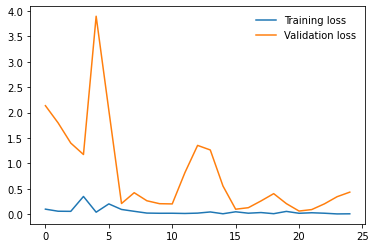

In [40]:
plt.plot(train_losses, label='Training loss')
plt.plot(test_losses, label='Validation loss')
plt.legend(frameon=False)
plt.show()

In [41]:
############## TENSORBOARD ########################
writer.close()
###################################################